For processing .accdb files, first replace ~^~ with ; then replace ~ with nothing
Then we can ingest it as a csv with sep=";" into pandas df

In [876]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import numpy as np
import os
# df = pd.read_excel("./data/2015-2016 FNDDS At A Glance - Ingredient Nutrient Values.xlsx")
df4 = pd.read_excel("./data/ABBREV.xlsx")
abs = pd.read_csv("./data/abbreviations.csv")
data = df4

### ABBREV (Nutrient Composition) Preprocessing

Get the food group description name for the nutrient composition database and merge it with that data

In [784]:
# Merge the NDB_No with the Food group code so we can get the food group and mix/match
food_group_code = pd.read_csv("./data/FOOD_DES (copy).txt", sep=";", error_bad_lines=False, header=None, usecols=[0,1,2,3])
# Table 4 page 37 in sr28doc
food_group_code.columns = ["NDB_No", "FdGrp_Cd", "Long_Desc", "Shrt_Desc"]

# Merge the food group code with the food group desc so we can match on english 
food_group_desc = pd.read_csv("./data/FD_GROUP.txt", sep=";", error_bad_lines=False, header=None)
# Table 5 page 38 in sr28doc
food_group_desc.columns = ["FdGrp_Cd", "FdGrp_Desc"]
# food_group_desc.head()

In [785]:
print("number of food groups")
len(np.unique(food_group_code.FdGrp_Cd))

# print("Food groups:")
# for x in np.unique(food_groups.FdGrp_Desc):
#     print(x)

number of food groups


25

In [786]:
 food_groups = food_group_code.merge(food_group_desc, on="FdGrp_Cd")

In [787]:
# Table 6 and 7 page 38 in sr28doc
langual = pd.read_csv("./data/LANGUAL.txt", sep=";", error_bad_lines=False, header=None)
langual.columns = ["NDB_No", "Factor_Code"]
langual.head()
langdesc = pd.read_csv("./data/LANGDESC.txt", sep=";", error_bad_lines=False, header=None)
langdesc.columns = ["Factor_Code", "Factor_Desc"]

In [788]:
factors = langdesc.merge(langual, on="Factor_Code")

In [789]:
1# WEights - table 12 pg 43 sr28
units = pd.read_csv("./data/WEIGHT.txt", sep=";", error_bad_lines=False, header=None, usecols=[0,1,2,3])
units.reset_index()
units.columns = ['NDB_No', "Seq", "Amount", "Unit"]
len(np.unique(units.NDB_No))

8492

In [790]:

# display(units.head(20))
# Drop items that contain the weird "pat" unit if they have more than 1 unit measurements for that NBD_No
for item in units.groupby("NDB_No"):
    if item[1].shape[0] >1 and any(item[1].Unit.str.contains("pat")):
#         print(item[1][item[1].Unit.str.contains("pat")])
        units.drop(index=item[1][item[1].Unit.str.contains("pat")].index.values, inplace=True)
# display(units.head(20))


In [791]:
len(np.unique(units.NDB_No))
# We lost 3 items, deal with this later...
# units.shape

8489

In [792]:
len(np.unique(units[units.Seq == 1].NDB_No))
# We lost 16 items? deal with this later...
# units.to_csv("./data/units.csv", index=False)

8471

Units extraction

In [793]:
# units = pd.read_csv("./data/units.csv")
np.unique(units.Unit)
print(units.shape)
# Let's exclude the items with arbitrary units (bowl, burger, breast, biscuit...)
# units = units[units.Unit.str.lower().str.contains("cup")]
searchfor = ["cup", "oz" ,"tbsp", "tsp"]
units_unused = units[~units.Unit.str.lower().str.contains('|'.join(searchfor))]
units = units[units.Unit.str.lower().str.contains('|'.join(searchfor))]
print(units.shape)

(15400, 4)
(9176, 4)


In [794]:
# units[units.Seq == 1].head(20)
# Just use one measurement unit
units = units[units.Seq == 1]

In [795]:
data = df4.merge(food_groups, on="NDB_No")
# data = data.merge(factors, on="NDB_No")
data = data.merge(units, on="NDB_No")

In [796]:
# factors[factors.NDB_No == 2001]
units[units.NDB_No == 2001]
# Multiple measurement types... let's merge on first one (seq = 1)

,NDB_No,Seq,Amount,Unit
587,2001,1,1.0,tsp


In [797]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
#     display(data[data.Shrt_Desc_x.str.contains("ALLSPICE")].head())

### Calorie needs preprocessing

* Expand age ranges to discrete ages

In [798]:
calorie_needs_m = pd.read_csv("./data/est_calorie_needs_male2.csv", sep='\t')
calorie_needs_m['Gender'] = 'Male'
calorie_needs_m.columns = [col.strip() for col in calorie_needs_m.columns]
calorie_needs_f = pd.read_csv("./data/est_calorie_needs_female.csv", sep='\t')
calorie_needs_f['Gender'] = 'Female'
calorie_needs_f.columns = [col.strip() for col in calorie_needs_f.columns]
calorie_needs = pd.concat([calorie_needs_f, calorie_needs_m])
# Strip all cols
calorie_needs[calorie_needs.columns] = calorie_needs.apply(lambda x: x.str.strip())
calorie_needs.reset_index(inplace=True, drop=True)
# Expand out initial age ranges to discrete ages for user input matching
new_ages = pd.DataFrame(columns=calorie_needs.columns)
for row in calorie_needs.iterrows():
    if '-' in row[1].AGE:
        item = row[1]
        age_start, age_end = item['AGE'].split('-')
        age_range = list(range(int(age_start), int(age_end)+1))
        for new_age in age_range:
            new_ages= new_ages.append({'AGE': new_age, 
                                  'Sedentary': item.Sedentary,
                                  'Moderately_active': item.Moderately_active,
                                  'Active': item.Active,
                                  'Gender': item.Gender
                                 }, ignore_index=True)
        calorie_needs.drop(index=row[0], inplace=True)
calorie_needs= calorie_needs.append(new_ages, ignore_index=True)
for x in calorie_needs[calorie_needs.AGE == '76 and up'].iterrows():
    calorie_needs.drop(index=x[0], inplace=True)
# Reformat str to int for matching
calorie_needs['Sedentary']= calorie_needs['Sedentary'].apply(lambda x: int(x.replace(",", "")) if isinstance(x, str) else x)
calorie_needs['Moderately_active']= calorie_needs['Sedentary'].apply(lambda x: int(x.replace(",", "")) if isinstance(x, str) else x)
calorie_needs['Active']= calorie_needs['Sedentary'].apply(lambda x: int(x.replace(",", "")) if isinstance(x, str) else x)
# calorie_needs['AGE']= calorie_needs['Sedentary'].apply(lambda x: int(x.replace(",", "")) if isinstance(x, str) else x)
calorie_needs.head()
# calorie_needs.to_csv("./data/calorie_needs.csv", index=False)

,AGE,Sedentary,Moderately_active,Active,Gender
0,2,1000,1000,1000,Female
1,3,1000,1000,1000,Female
2,4,1200,1200,1200,Female
3,5,1200,1200,1200,Female
4,6,1200,1200,1200,Female


In [799]:
calorie_needs.head()

,AGE,Sedentary,Moderately_active,Active,Gender
0,2,1000,1000,1000,Female
1,3,1000,1000,1000,Female
2,4,1200,1200,1200,Female
3,5,1200,1200,1200,Female
4,6,1200,1200,1200,Female


### Price data (2010)

We calculate the price per 100 grams (unit value) for each purchase of each food item. For dry weights, we use a conversion of 28.35 grams per ounce, and a conversion factor of 29.57 grams per ounce for liquids.9 In some cases, however, only the number of items purchased (e.g., ears of corn) is reported. In these cases, we used the USDA National Nutrient Database for Standard Reference (Release 20) to convert the unit counts to weight, assuming the food was medium-sized (if there are multiple sizes in the database). Although it was possible to convert most unit counts to gram weights using this approach, not all purchases reported only as counts were convertible. Those food items that were not converted were excluded from the price calculations.10

In [800]:
# Lets get the latest Los Angeles (15) prices for each category and manually average them for the
# FdGrp_Desc categories 
qrs_fns = [qr for qr in os.listdir("./data") if "qfahpd2" in qr and 'lock' not in qr]
qrs = []
price_df = pd.DataFrame(columns=['qr', 'year', 'price', 'marketgroup'])
for i, qr in enumerate(qrs_fns):
    print(qr)
    xls = pd.ExcelFile("./data/"+qr)
    for sht in xls.sheet_names:
        if sht.isnumeric():
#             print(sht)
            xldf = pd.read_excel("./data/"+qr, sheet_name=sht)
            qrcat_sheets.append(xldf)
            latest_year = np.unique(xldf.year)[-1]
            marketgroup = 15
            # Median price for this food group for specified marketgroup region
            median_fdgrp_sht_price = xldf[(xldf.year == latest_year) & (xldf['marketgroup'] == marketgroup)].price.median()
            price_df= price_df.append({'qr': qr, 'year': latest_year, 'sheet': sht,
                                       'price': median_fdgrp_sht_price, 'marketgroup': 15},
                                      ignore_index=True)


qfahpd2grainsanddairy.xls
qfahpd2fatsandpreparedfoods.xls
qfahpd2fruitsandvegetables.xls
qfahpd2meatsandeggs.xls


    Map market code description to FdGrp_Desc

In [801]:
def get_price_for_fdgrp(fdgrp, price_df):
    if fdgrp.strip() == 'Baby Foods':
        return price_df[price_df.sheet == '1'].price.values[0]
    elif fdgrp.strip() == 'Fruits and Fruit Juices':
        return price_df[price_df.sheet.isin(['1','2','3'])].price.values.mean()
    elif fdgrp.strip() == 'Vegetables and Vegetable Products':
        return price_df[price_df.sheet.isin(['4','5','6','7','8','9','10'])].price.values.mean()
    elif fdgrp.strip() == 'Vegetables and Vegetable Products':
        return price_df[price_df.sheet.isin(['4','5','6','7','8','9','10', '11','12','13'])].price.values.mean()
    elif fdgrp.strip() == 'Legumes and Legume Products':
        return price_df[price_df.sheet.isin(['14','15'])].price.values.mean()
    elif fdgrp.strip() == 'Breakfast Cereals':
        return price_df[price_df.sheet.isin(['16', '18', '19', '21'])].price.values.mean()
    elif fdgrp.strip() == 'Cereal Grains and Pasta':
        return price_df[price_df.sheet.isin(['16', '19'])].price.values.mean()
    elif fdgrp.strip() == 'Dairy and Egg Products':
        return price_df[price_df.sheet.isin(['24','25','26','27', '37'])].price.values.mean()
    elif fdgrp.strip() == 'Beef Products':
        return price_df[price_df.sheet.isin(['28', '29', '30'])].price.values.mean()
    elif fdgrp.strip() == 'Lamb, Veal, and Game Products':
        return price_df[price_df.sheet.isin(['28', '29'])].price.values.mean()
    elif fdgrp.strip() == 'Pork Products':
        return price_df[price_df.sheet.isin(['28', '29'])].price.values.mean()
    elif fdgrp.strip() == 'Nut and Seed Products':
        return price_df[price_df.sheet.isin(['35', '36'])].price.values.mean()
    elif fdgrp.strip() == 'Fats and Oils':
        return price_df[price_df.sheet.isin(['38', '39'])].price.values.mean()
    elif fdgrp.strip() == 'Beverages':
        return price_df[price_df.sheet.isin(['41', '42', '43'])].price.values.mean()
    elif fdgrp.strip() == 'Baked Products':
        return price_df[price_df.sheet.isin(['46'])].price.values.mean()
    elif fdgrp.strip() == 'Sweets':
        return price_df[price_df.sheet.isin(['44','45','46'])].price.values.mean()
    elif fdgrp.strip() == 'Soups, Sauces, and Gravies':
        return price_df[price_df.sheet.isin(['49'])].price.values.mean()
    elif fdgrp.strip() == 'Snacks':
        return price_df[price_df.sheet.isin(['50'])].price.values.mean()
    elif fdgrp.strip() == 'Sausages and Luncheon Meats':
        return price_df[price_df.sheet.isin(['51', '52'])].price.values.mean()
    elif fdgrp.strip() == 'Finfish and Shellfish Products':
        return price_df[price_df.sheet.isin(['51', '52'])].price.values.mean()
    else:
        return 1
    

Get the prices for each food item based on their food group and it's map to the QFHPD food group, and merge the prices for each food item to the main data

In [802]:
data['FdGrp_Price'] = data.FdGrp_Desc.apply(get_price_for_fdgrp, price_df=price_df)

In [803]:
market_group = 15 # Los angeles - See first page of XLS
gd_prices = pd.read_excel("./data/price_data/qfahpd2grainsanddairy.xls", sheet_name="16")
gd_prices= gd_prices[gd_prices.marketgroup == 15]

In [804]:
gd_prices.sort_values("year", ascending=False, inplace=True)
gd_prices.head()
# PRICE PER 100 GRAMS...
# See https://www.ers.usda.gov/webdocs/publications/47564/8516_tb1926_1_.pdf?v=0

,marketgroup,year,quarter,price,se,n,division,region,aggweight,totexp
419,15,2010,4,0.520149,0.008799,1337,9,4,5760010,5.099422e+07
418,15,2010,3,0.523133,0.008323,1440,9,4,5760010,5.999274e+07
417,15,2010,2,0.507397,0.008272,1477,9,4,5760010,6.278373e+07
416,15,2010,1,0.523540,0.007792,1454,9,4,5760010,6.326863e+07
415,15,2009,4,0.490152,0.008087,1300,9,4,5755128,5.089855e+07


### RDA data preprocessing

* Expand age ranges to discrete ages

In [805]:
import os
nut_files = [x for x in os.listdir("./data/") if "nut_intake" in x]
RDA_inputs = []
for nut_intake_file in nut_files:
#     RDA = pd.read_csv("./data/nut_intake.csv" , sep="\t")
    RDA = pd.read_csv("./data/"+nut_intake_file , sep="\t")
    RDA_inputs.append(RDA)
    
# RDA = pd.concat(RDA_inputs)

In [806]:
# [col.split()[0] for col in RDA.columns]
stacked = [RDA[RDA.columns[1:]].stack() for RDA in RDA_inputs]
# stacked['gender'] = stacked.index[]

In [807]:
RDAt = [RDA.transpose() for RDA in RDA_inputs]
# RDAt['Gender'] = RDAt.apply(lambda z: z.index.values, axis=1)

In [808]:
# [idx for idx in RDAt.index[1:]]
# [idx.split()[1] for idx in RDAt.index[1:]]
RDAt2 = [RDAt_i.reset_index() for RDAt_i in RDAt]


In [809]:
RDAt3 = [RDAt_i.rename(columns={"index": "Gender"}) for RDAt_i in RDAt2]

In [810]:
RDAt3[1].head()

,Gender,Calorie level(s) assessed,Macronutrients,"Protein, g","Protein, % kcal","Carbohydrate, g","Carbohydrate, % kcal","Dietary fiber, g","Added sugars, % kcal","Total fat, % kcal",...,"Vitamin D, IU","Vitamin C, mg","Thiamin, mg","Riboflavin, mg","Niacin, mg","Vitamin B6, mg","Vitamin B12, mcg","Choline, mg","Vitamin K, mcg","Folate, mcg DFE"
0,Child 1-3,"1,000",NaN,13,5-20,130,45-65,14,<10%,30-40,...,600,15,0.5,0.5,6,0.5,0.9,200,30,150
1,Female 4-8,"1,200",NaN,19,10-30,130,45-65,16.8,<10%,25-35,...,600,25,0.6,0.6,8,0.6,1.2,250,55,200
2,Male 4-8,"1,400 1,600",NaN,19,10-30,130,45-65,19.6,<10%,25-35,...,600,25,0.6,0.6,8,0.6,1.2,250,55,200
3,Female 9-13,"1,600",NaN,34,10-30,130,45-65,22.4,<10%,25-35,...,600,45,0.9,0.9,12,1,1.8,375,60,300
4,Male 9-13,"1,800",NaN,34,10-30,130,45-65,25.2,<10%,25-35,...,600,45,0.9,0.9,12,1,1.8,375,60,300


In [811]:
# RDAt['Age'] = RDAt['Gender'].apply(lambda z: z.split()[1])
# RDAt['Gender'] = RDAt['Gender'].apply(lambda z: z.split()[0])
for rda in RDAt3:
    rda['Age'] = rda['Gender'].apply(lambda z: z.split()[1])
    rda['Gender'] = rda['Gender'].apply(lambda z: z.split()[0])

In [812]:
RDAt_f = pd.concat(RDAt3)

/home/celeste/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [813]:
RDAt_f.head(20)

,"1,000 kcal","Added sugars, % kcal",Age,"Calcium, mg",Calorie level(s) assessed,"Carbohydrate, % kcal","Carbohydrate, g","Choline, mg","Copper, mcg","Dietary fiber, g",...,"Total fat, % kcal","Vitamin A, mcg RAE","Vitamin B12, mcg","Vitamin B6, mg","Vitamin C, mg","Vitamin D, IU","Vitamin E, mg AT","Vitamin K, mcg",Vitamins,"Zinc, mg"
0,14,DGA,of,RDA,NaN,AMDR,RDA,AI,RDA,14g/,...,AMDR,RDA,RDA,RDA,RDA,RDA,RDA,AI,NaN,RDA
1,16.8,<10%,1-3,700,NaN,45-65,130,200,340,NaN,...,30-40,300,0.9,0.5,15,600,6,30,NaN,3
2,19.6,<10%,4-8,"1,000",NaN,45-65,130,250,440,NaN,...,25-35,400,1.2,0.6,25,600,7,55,NaN,5
3,22.4,<10%,4-8,"1,000",NaN,45-65,130,250,440,NaN,...,25-35,400,1.2,0.6,25,600,7,55,NaN,5
4,25.2,<10%,9-13,"1,300",NaN,45-65,130,375,700,NaN,...,25-35,600,1.8,1,45,600,11,60,NaN,8
5,25.2,<10%,9-13,"1,300",NaN,45-65,130,375,700,NaN,...,25-35,600,1.8,1,45,600,11,60,NaN,8
6,30.8,<10%,14-18,"1,300",NaN,45-65,130,400,890,NaN,...,25-35,700,2.4,1.2,65,600,15,75,NaN,9
7,NaN,<10%,14-18,"1,300",NaN,45-65,130,550,890,NaN,...,25-35,900,2.4,1.3,75,600,15,75,NaN,11
0,NaN,<10%,1-3,700,"1,000",45-65,130,200,340,14,...,30-40,300,0.9,0.5,15,600,6,30,NaN,3
1,NaN,<10%,4-8,"1,000","1,200",45-65,130,250,440,16.8,...,25-35,400,1.2,0.6,25,600,7,55,NaN,5


In [814]:
# RDAt.to_csv("./data/RDAt.csv", index=False)

In [815]:
# Expand out initial age ranges to discrete ages for user input matching
RDAt_f.reset_index()
RDAt = RDAt_f
RDAt.reset_index(inplace=True)

In [816]:
new_ages = pd.DataFrame(columns=RDAt.columns)
for row in RDAt.iterrows():
#     print(row[1])
    if '-' in row[1].Age:
        item = row[1]
        age_start, age_end = item['Age'].split('-')
        age_range = list(range(int(age_start), int(age_end)+1))
#         print(age_range)
        for new_age in age_range:
            new_item = item
            new_item['Age'] = new_age
            new_ages= new_ages.append(new_item, ignore_index=True)
        RDAt.drop(index=row[0], inplace=True)
        

In [817]:
RDAt= RDAt.append(new_ages, ignore_index=True)

In [818]:
for x in RDAt[RDAt.Age == '51+'].iterrows():
    RDAt.drop(index=x[0], inplace=True)

In [819]:
RDAt.drop(index=RDAt[RDAt['Gender'] =='Source'].index, inplace=True)

In [820]:
# RDAt.to_csv("./data/RDA_fixed.csv", index=False)

In [821]:
data.columns = [z.replace("_"," ").replace("(","").replace(")","") for z in data.columns.values]

In [822]:
# data.to_csv("./data/data.csv", index=False)

Manipulate plant based trend data and plot it for intro

Text(0.5, 0, 'Date')

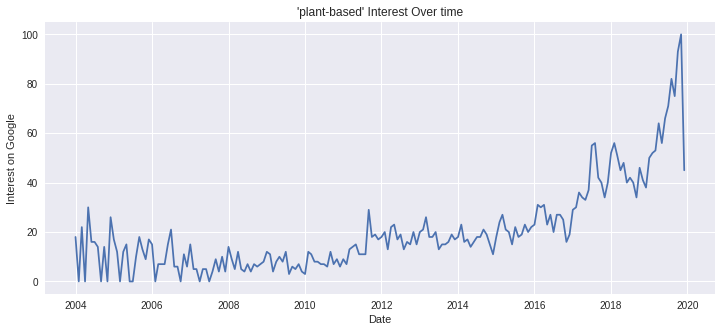

In [885]:
import datetime
plantbased = pd.read_csv("./data/plantbased-googletrends.csv")
plantbased.columns = ["'plant-based' Interest Over time"]
plantbased = plantbased[1:]
plantbased.index = plantbased.reset_index()['index'].apply(lambda z: datetime.datetime.strptime(z, '%Y-%m'))
plantbased[plantbased.columns[0]]= plantbased[plantbased.columns[0]].apply(int)
plt.figure(figsize=(12,5))
p = plt.plot(plantbased)
t = plt.title(plantbased.columns[0])
plt.ylabel("Interest on Google")
plt.xlabel("Date")